# Tensorflow training  
Es ist zu vermuten, dass ein Neuronales Netz, das auf das Erkennen von Plakaten trainiert worden ist zu sinnigeren Clustern kommt. Von daher soll mittels dieses Notebooks ein Neuronales Netz auf einen Trainingsdatensatz trainiert werden.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
path = "/home/julius/PowerFolders/Masterarbeit/1_Datensaetze/tensorflow"

In [4]:
train_dataset = image_dataset_from_directory(path, shuffle=True, image_size=(160, 160))

Found 800 files belonging to 8 classes.


In [5]:
class_names = train_dataset.class_names

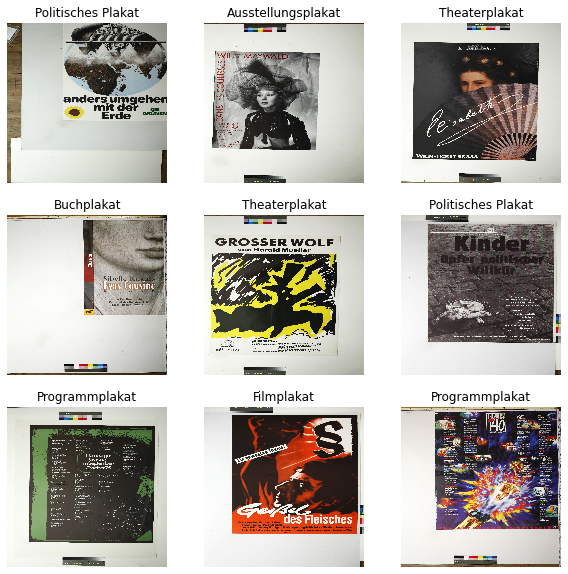

In [6]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")